# Identificación de Retinopatía Diabética con MobileNet

In [3]:
from sklearn.metrics import classification_report

from tesis_lib.io.hdf5datasetgenerator import HDF5DatasetGenerator
from tesis_lib.datasets.rosenbrock_loader import RosenbrockLoader
from tesis_lib.callbacks.trainingmonitor import TrainingMonitor
from tesis_lib.preprocessing.imagetoarrayprocessor import ImageToArrayPreprocessor
from tesis_lib.preprocessing.aspectawareprocessor import AspectAwareProcessor
from tesis_lib.preprocessing.patchpreprocessor import PatchPreprocessor
from tesis_lib.preprocessing.meanpreprocessor import MeanPreprocessor
from tesis_lib.preprocessing.simplepreprocessor import SimpleProcessor

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Dropout, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import progressbar
import json
import cv2
import os

In [ ]:
TIME_STAMP = datetime.today().strftime("%d_%m_%Y_%H_%M")

In [ ]:
DATASET_PATH = './DB'

FILENAME = f'ident_mobilenet_{TIME_STAMP}'

MODEL_OUT_PATH = f'./models/{FILENAME}.h5'
OUTPUT_PATH = F'./output/{FILENAME}'

BATCH_SIZE = 32
EPOCHS = 150
IM_SIZE = 300
NUM_CLASSES = 4

LEARNING_RATE = 1e-3
DROP_FACTOR = 0.10
DROP_EPOCHS = 10

In [ ]:
# train_ds = image_dataset_from_directory(
#     os.path.sep.join([DATASET_PATH, 'Train']),
#     # validation_split=0.2,
#     # subset='training',
#     seed=123,
#     image_size=(IM_SIZE,IM_SIZE),
#     crop_to_aspect_ratio=True,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     label_mode='categorical'
# )

In [ ]:
class_names = train_ds.class_names
class_names

In [ ]:
for imgs, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.axis("off")

In [ ]:
# val_ds = image_dataset_from_directory(
#     os.path.sep.join([DATASET_PATH, 'Val']),
#     # validation_split=0.2,
#     # subset='training',
#     seed=123,
#     image_size=(IM_SIZE,IM_SIZE),
#     crop_to_aspect_ratio=True,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     label_mode='categorical'
# )
# test_ds = image_dataset_from_directory(
#     os.path.sep.join([DATASET_PATH, 'Test']),
#     # validation_split=0.2,
#     # subset='training',
#     seed=123,
#     image_size=(IM_SIZE,IM_SIZE),
#     crop_to_aspect_ratio=True,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     label_mode='categorical'
# )

In [ ]:
# for imgs, labels in val_ds.take(1):
#     for i in range(4):
#         ax = plt.subplot(2,2,i+1)
#         plt.imshow(imgs[i].numpy().astype('uint8'))
#         plt.axis("off")

In [ ]:
# for imgs, labels in test_ds.take(1):
#     for i in range(4):
#         ax = plt.subplot(2,2,i+1)
#         plt.imshow(imgs[i].numpy().astype('uint8'))
#         plt.axis("off")

In [225]:
import random

train_batches = ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rescale=1./255,
    rotation_range=25, 
    # shear_range=0.20, 
    # zoom_range=0.15,
    # width_shift_range=0.1,
    # height_shift_range=0.1, 
    # horizontal_flip=True, 
    # fill_mode='nearest'
).flow_from_directory(
    directory=os.path.sep.join([DATASET_PATH, 'Train']),
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    keep_aspect_ratio=True
)


val_batches = ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rescale=1./255,
).flow_from_directory(
    directory=os.path.sep.join([DATASET_PATH, 'Val']),
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    keep_aspect_ratio=True
)
test_batches = ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rescale=1./255,
).flow_from_directory(
    directory=os.path.sep.join([DATASET_PATH, 'Test']),
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    keep_aspect_ratio=True
)

Found 2251 images belonging to 4 classes.
Found 1400 images belonging to 4 classes.
Found 1432 images belonging to 4 classes.


[INFO] train example images


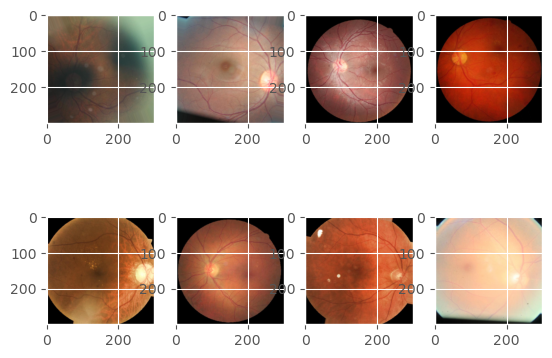

[INFO] val example images


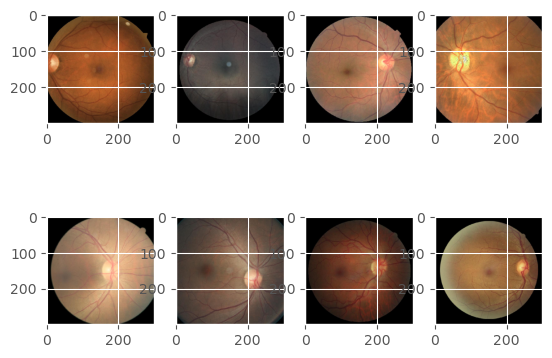

[INFO] test example images


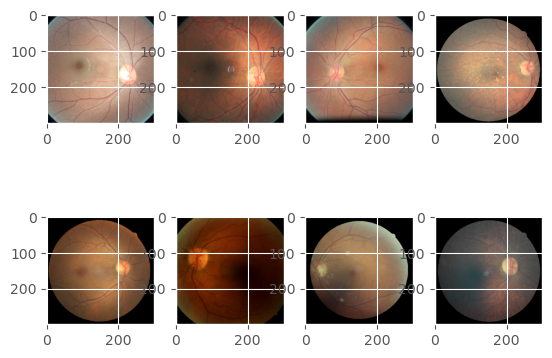

In [226]:
import random

def explore(batch: tuple, title:str):
    print(f"[INFO] {title} example images")
    example_batch, _ = batch[0]

    index = random.randint(0,24)
    for i, img in enumerate(example_batch[index:index+8]):
        plt.subplot(2,4,i+1)
        plt.imshow(img)

    plt.show()

explore(train_batches,'train')
explore(val_batches, 'val')
explore(test_batches, 'test')

In [227]:
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

In [228]:
print("[INFO] Compiling model ...")

opt = Adam(lr=LEARNING_RATE)

DROPOUT_RATE = 0.5

model = MobileNet(
    input_shape=(IM_SIZE,IM_SIZE,3),
    alpha=1.0,
    include_top=True,
    weights=None,
    pooling='max',
    classes=NUM_CLASSES,
    classifier_activation='softmax'
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

monitor_path = os.path.sep.join([OUTPUT_PATH,f"{FILENAME}.jpg"])

checkpoint = ModelCheckpoint(
    MODEL_OUT_PATH, 
    monitor="val_loss", 
    mode='min', 
    save_best_only=True,
    verbose=1)

callbacks = [
    checkpoint,
    TrainingMonitor(monitor_path)
]

display(model.summary())

print(f"[INFO] training model ...")

H = model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=val_batches,
    validation_steps=len(val_batches),
    epochs= EPOCHS,
    max_queue_size=10,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

[INFO] Compiling model ...
Model: "mobilenet_1.00_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 150, 150, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 150, 150, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 150, 150, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 150, 150, 32)     128       
 ation)              

None

[INFO] training model ...
Epoch 1/150
71/71 [==============================] - ETA: 0s - loss: 1.4768 - accuracy: 0.2634
Epoch 1: val_loss improved from inf to 1.51259, saving model to ./models/ident_mobilenet_04_02_2023_10_46.h5
71/71 [==============================] - 127s 2s/step - loss: 1.4768 - accuracy: 0.2634 - val_loss: 1.5126 - val_accuracy: 0.2507
Epoch 2/150
71/71 [==============================] - ETA: 0s - loss: 1.4501 - accuracy: 0.2590
Epoch 2: val_loss did not improve from 1.51259
71/71 [==============================] - 122s 2s/step - loss: 1.4501 - accuracy: 0.2590 - val_loss: 1.6382 - val_accuracy: 0.2507
Epoch 3/150
71/71 [==============================] - ETA: 0s - loss: 1.4445 - accuracy: 0.2688
Epoch 3: val_loss did not improve from 1.51259
71/71 [==============================] - 122s 2s/step - loss: 1.4445 - accuracy: 0.2688 - val_loss: 1.6087 - val_accuracy: 0.2507
Epoch 4/150
71/71 [==============================] - ETA: 0s - loss: 1.4151 - accuracy: 0.2657
E

KeyboardInterrupt: 

## Making predictions and evaluating the model

In [9]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    MATRIX_PATH = os.path.sep.join([OUTPUT_PATH, f'cm-{FILENAME}.jpg'])
    plt.savefig(MATRIX_PATH)
    plt.show()

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, class_likelihood_ratios
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tesis_lib.utils.ranked import rank5_accuracy
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

MODEL_LOAD_PATH = 'models/ident_mobilenet_04_02_2023_10_46.h5'
DATASET_PATH = './DB'


BATCH_SIZE = 32
IM_SIZE = 300
# NUM_CLASSES = 4

In [6]:


test_batches = ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rescale=1./255,
).flow_from_directory(
    directory=os.path.sep.join([DATASET_PATH, 'Test']),
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    keep_aspect_ratio=True
)

Found 1432 images belonging to 4 classes.


In [7]:
# load the pretrained network
print(f"[INFO] loading model {MODEL_LOAD_PATH}...")
model = load_model(MODEL_LOAD_PATH)

# initialize the testing dataset generator, then make predictions on
# the testing data
print("[INFO] predicting on test data (no crops)...")

predictions = model.predict(test_batches)

trueLabels = test_batches.classes
predictedLabels = list(predictions.argmax(axis=1))



[INFO] loading model models/ident_mobilenet_04_02_2023_10_46.h5...
[INFO] predicting on test data (no crops)...
45/45 [==============================] - 22s 490ms/step


[INFO] rank-1: 60.34%


[INFO] Calculating Confusion Matrix
Confusion matrix, without normalization
[[201  55  65  46]
 [ 57 175  74  48]
 [ 39  26 236  56]
 [ 27  18  57 252]]


NameError: name 'OUTPUT_PATH' is not defined

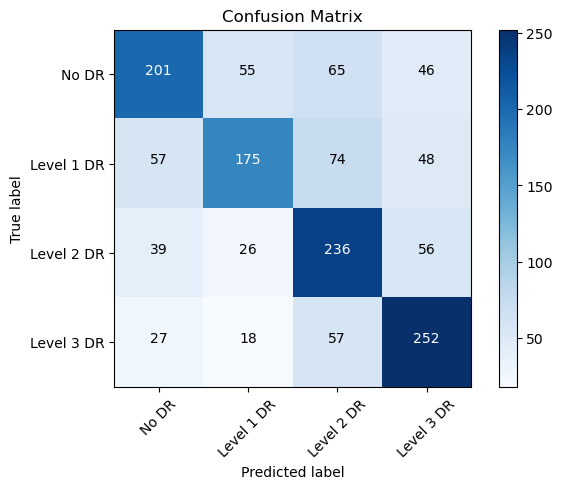

In [10]:
# compute the rank-1 and rank-5 accuracies
(rank1, _) = rank5_accuracy(predictions, trueLabels)
print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))

print("\n\n[INFO] Calculating Confusion Matrix")
cm = confusion_matrix(
    y_true = trueLabels,
    y_pred = predictedLabels
)
plot_confusion_matrix(cm, ['No DR', 'Level 1 DR', 'Level 2 DR', 'Level 3 DR'], False, "Confusion Matrix")

print("[INFO] Generating the Classification Report")
print(classification_report(
	y_true = trueLabels,
	y_pred = predictedLabels,
	target_names= ['No DR', 'Level 1 DR', 'Level 2 DR', 'Level 3 DR']
))